# Compare compression methods

Some installation stuff

In [ ]:
module load cudatoolkit/12.2
module load cudnn/8.9.3_cuda12
module load python
# Verify the versions of cudatoolkit and cudnn are compatible with JAX
module list
# Create a new conda environment 
conda create -n jax-demo python=3.9 pip numpy scipy
# Activate the environment before using pip to install JAX
conda activate jax-demo
# Install a compatible wheel
pip install --upgrade "jax[cuda12_local]" -f https://storage.googleapis.com/jax-releases/jax_cuda_releases.html

pip install --quiet dm-haiku optax

python -m ipykernel install --user --name jax-demo --display-name jax-demo

In [3]:
%matplotlib inline
import matplotlib.pyplot as plt

import frogress
import numpy as np
import jax
import copy
import jax.numpy as jnp

#Haiku is a simple neural network library for JAX 
import haiku as hk

#Optax is a gradient processing and optimization library for JAX. 
import optax

import sys
import tensorflow as tf
from tensorflow_probability.substrates import jax as tfp

from numpy.random import default_rng

                
    
tfd = tfp.distributions
tfb = tfp.bijectors

2024-02-16 13:14:53.540436: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-16 13:14:53.540482: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-02-16 13:14:53.542742: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-02-16 13:14:57.618175: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


# Load data

In [18]:
# Dirac + Dark Grid simulations and target datavector:
DD = np.load('/global/cfs/cdirs/des/mgatti/CMB_lensing/DV/SBI_forecast/compression/compression_data_combined.npy',allow_pickle=True).item()
stat = DD['stat']
mask = DD['mask']
target = DD['data']

# Load derivatives & covariance matrix
derivatives_dict = np.load('/global/cfs/cdirs/des/mgatti/CMB_lensing/DV/SBI_forecast/MOPED_derivatives.npy',allow_pickle=True).item()


statistic = 'WL_2' # let's start from something simple, i.e., WL second moments -------------------
number_of_params = 4 # Omega_m, S8, w, A_IA
weights_loss_MSE = np.array([ 50, 50, 1,  5 ]) # this reflects the fact we care more about Om S8 than w when using a MSE loss (which is barely learned)
weights_loss_MSE = weights_loss_MSE[:number_of_params]



'''
Data set preparation -------------------------------------------
'''
additional_mask = stat[statistic]['params'][:,2]>0.1
# these are the pars/DV that will be used for the compression.
pars = jnp.array(stat[statistic]['params'][mask&additional_mask,:number_of_params])
dv = jnp.array(stat[statistic]['dv'][mask&additional_mask,:])

# these are the pars/DV that will be used for the LFI step later on
pars_LFI = jnp.array(stat[statistic]['params'][(~mask)&additional_mask,:number_of_params])
dv_LFI = jnp.array(stat[statistic]['dv'][(~mask)&additional_mask,:])


len_dv = dv.shape[1]  
samples = dv.shape[0]

# split into training & validation for the compression -------
rng = default_rng()
numbers = rng.choice(samples , size=1000, replace=False)
special = np.in1d(np.arange(samples ),numbers)


pars_train = jnp.array(pars[~special])
pars_val =  jnp.array(pars[special])
dv_train = jnp.array(dv[~special])
dv_val = jnp.array(dv[special])

# normalise the DV
dv_val =    np.clip(0.5+0.2 * ( dv_val-np.median( dv,axis=0)) / np.std( dv, axis=0) ,-0.5,1.5)
dv_train =  np.clip(0.5+0.2 * ( dv_train-np.median( dv,axis=0)) / np.std( dv, axis=0) ,-0.5,1.5)
dv_LFI =    np.clip(0.5+0.2 * ( dv_LFI-np.median( dv,axis=0)) / np.std( dv, axis=0) ,-0.5,1.5)
dv_target = np.clip(0.5+0.2 * ( target[statistic]['dv']-np.median( dv,axis=0)) / np.std( dv, axis=0) ,-0.5,1.5)




In [24]:
# normalise the entries for the covariance and the derivatives
# increaments of the parameters for the numerical derivatives
delta = dict()
delta['delta_Om'] = 0.02
delta['delta_s8'] = 0.03
delta['delta_w0'] = 0.1
delta['delta_A'] = 0.2

derivatives = dict()
dv_cov  = np.clip(0.5+0.2 * ( derivatives_dict[statistic]['cov']-np.median( dv,axis=0)) / np.std( dv, axis=0) ,-0.5,1.5)
for key in delta.keys():
    dv_p  = np.clip(0.5+0.2 * ( derivatives_dict[statistic][key][0]-np.median( dv,axis=0)) / np.std( dv, axis=0) ,-0.5,1.5)
    dv_m  = np.clip(0.5+0.2 * ( derivatives_dict[statistic][key][1]-np.median( dv,axis=0)) / np.std( dv, axis=0) ,-0.5,1.5)
    derivatives[key] = [dv_p,dv_m]
        


# VMIM

In [49]:
class AffineCoupling(hk.Module):
    """
    Implements an affine coupling layer, a fundamental building block for normalizing flow models.

    Attributes:
    - scale_only (bool): If True, the coupling layer modifies the scale only. Otherwise, it modifies both scale and shift.

    Methods:
    - __call__(self, x, output_units, **condition_kwargs): Applies the affine transformation to input x.
    """

    def __init__(self, scale_only=True, **kwargs):
        """
        Initializes the AffineCoupling layer.

        Parameters:
        - scale_only (bool): Indicates whether the coupling layer should apply scaling only, without shifting.
        """
        super().__init__(**kwargs)
        self.scale_only = scale_only

    def __call__(self, x, output_units, **condition_kwargs):
        """
        Applies the affine coupling transformation to the input.

        Parameters:
        - x (jax.numpy.ndarray): Input tensor to the coupling layer.
        - output_units (int): The size of the output dimension.
        - **condition_kwargs: Optional keyword arguments, including 'cond' for conditional inputs.

        Returns:
        - A TensorFlow Probability Bijector applying the affine transformation, with optional scaling and shifting.
        """
        # If conditional input is provided, concatenate it with x.
        if 'cond' in condition_kwargs:
            x = jnp.concatenate([x, condition_kwargs['cond']], axis=-1)
        
        # Apply a sequence of linear transformations and non-linear activations.
        net = hk.Linear(128)(x)
        net = jax.nn.leaky_relu(net)
        net = hk.Linear(128)(net)
        net = jax.nn.leaky_relu(net)
        
        # Create the shifting transformation.
        shifter = tfb.Shift(hk.Linear(output_units)(net))
        
        # Depending on `scale_only`, either return the shifter or include a scaling transformation.
        if self.scale_only:
            return shifter
        else:
            scaler = tfb.Scale(jnp.clip(jax.nn.softplus(hk.Linear(output_units)(net)), 1e-2, 1e1))
            return tfb.Chain([shifter, scaler])
        
        
class AffineFlow(hk.Module):
    """
    Constructs a normalizing flow model using a series of AffineCoupling layers and permutations.

    Attributes:
    - d (int): The dimensionality of the input data.

    Methods:
    - __call__(self): Constructs and returns the normalizing flow model.
    """

    def __init__(self, d=number_of_params, name=None):
        """
        Initializes the AffineFlow model.

        Parameters:
        - d (int): The dimensionality of the input data.
        - name (str, optional): Name of the module.
        """
        super().__init__(name=name)
        self.d = d

    def __call__(self):
        """
        Constructs the normalizing flow model.

        Returns:
        - A TensorFlow Probability TransformedDistribution representing the normalizing flow model.
        """
        # Define a chain of bijectors including RealNVP and Permute layers.
        chain = tfb.Chain([
            tfb.RealNVP(self.d//2, bijector_fn=AffineCoupling(name='aff1'), name="nvp1"),
            tfb.Permute(jnp.arange(self.d)[::-1]),
            tfb.RealNVP(self.d//2, bijector_fn=AffineCoupling(name='aff2'), name="nvp2"),
            tfb.Permute(jnp.arange(self.d)[::-1]),
            tfb.RealNVP(self.d//2, bijector_fn=AffineCoupling(name='aff3', scale_only=False), name="nvp3"),
            tfb.Permute(jnp.arange(self.d)[::-1]),
            tfb.RealNVP(self.d//2, bijector_fn=AffineCoupling(name='aff4', scale_only=False), name="nvp4"),
            tfb.Permute(jnp.arange(self.d)[::-1]),
        ])
        
        # Define the base distribution as a Multivariate Normal Diag.
        nvp = tfd.TransformedDistribution(
            distribution=tfd.MultivariateNormalDiag(loc=jnp.zeros(self.d), scale_diag=jnp.ones(self.d)),
            bijector=chain)
        
        return nvp


    
#

class Compressor_old(hk.Module):
  """ 
  This module implements neural compression
  """
  def __call__(self, x):
    net = hk.Linear(512)(x)
    net = jax.nn.leaky_relu(net)
    net = hk.Linear(512)(net)
    net = jax.nn.leaky_relu(net)
    net = hk.Linear(number_of_params)(net)
    return net


class Compressor(hk.Module):
  """ 
  This module implements neural compression
  """
  def __call__(self, x):
    net = hk.Linear(1900)(x)
    net = jax.nn.leaky_relu(net, negative_slope=0.01)
    net = hk.Linear(1500)(x)
    net = jax.nn.leaky_relu(net, negative_slope=0.01)
    net = hk.Linear(900)(net)
    net = jax.nn.leaky_relu(net, negative_slope=0.01)
    net = hk.Linear(500)(net)
    net = jax.nn.leaky_relu(net, negative_slope=0.01)
    #net = hk.Linear(100)(net)
    #net = jax.nn.relu(net)
    #net = hk.Linear(100)(net)
    #net = jax.nn.relu(net)
    #net = hk.Linear(number_of_params)(net)
    
    outputs = []
    for _ in range(number_of_params):  # Assuming 4 separate outputs
        branch = hk.Linear(100)(net)
        branch = jax.nn.relu(branch)
        branch = hk.Linear(100)(branch)
        branch = jax.nn.relu(branch)
        branch_output = hk.Linear(1)(branch)  # Output layer for each parameter
        outputs.append(branch_output)

    # Concatenate the 4 outputs to return a single vector with 4 parameters
    net = jax.numpy.concatenate(outputs, axis=-1)

    return net




class Compressor(hk.Module):
  """ 
  This module implements neural compression
  """
  def __call__(self, x):
    #net = hk.Linear(900)(x)
    #net = jax.nn.leaky_relu(net, negative_slope=0.01)
    #net = hk.Linear(800)(branch)
    #net = jax.nn.leaky_relu(net, negative_slope=0.01)
    
    #net = hk.Linear(100)(net)
    #net = jax.nn.relu(net)
    #net = hk.Linear(100)(net)
    #net = jax.nn.relu(net)
    #net = hk.Linear(number_of_params)(net)
    
    outputs = []
    for _ in range(number_of_params):  # Assuming 4 separate outputs
        branch = hk.Linear(900)(x)
        branch = jax.nn.leaky_relu(branch, negative_slope=0.01)
        branch = hk.Linear(800)(branch)
        branch = jax.nn.leaky_relu(branch, negative_slope=0.01)

        branch = hk.Linear(100)(branch)
        branch = jax.nn.relu(branch)
        branch = hk.Linear(100)(branch)
        branch = jax.nn.relu(branch)
        branch_output = hk.Linear(1)(branch)  # Output layer for each parameter
        outputs.append(branch_output)

    # Concatenate the 4 outputs to return a single vector with 4 parameters
    net = jax.numpy.concatenate(outputs, axis=-1)

    return net




In [50]:
# transform into tensorflow arrays 
dset_x = tf.data.Dataset.from_tensor_slices(pars_train)
dset_x_val = tf.data.Dataset.from_tensor_slices(pars_val)
dset_y = tf.data.Dataset.from_tensor_slices(dv_train)
dset_y_val = tf.data.Dataset.from_tensor_slices(dv_val)
dset = tf.data.Dataset.zip((dset_x, dset_y))
dset_y_val = tf.data.Dataset.zip((dset_x_val, dset_y_val))


#Caches the dataset in memory or on disk, which can improve performance
dset = dset.cache()
dset_y_val = dset_y_val.cache()

# Repeats the dataset indefinitely, 
# allowing for multiple epochs of training without needing to manually reset the iterator.
dset = dset.repeat()
dset_y_val = dset_y_val.repeat()

#Randomly shuffles the elements of the dataset using a buffer of size 2000.
dset = dset.shuffle(2000)
dset_y_val = dset_y_val.shuffle(2000)
#Groups the dataset elements into batches of 128. 
# Batching is essential for training models efficiently, allowing for parallel computation over a batch of data.
dset = dset.batch(128)
dset_y_val = dset_y_val.batch(128)

#Creates an iterator that will return the elements of the dataset as NumPy arrays. 
# This allows for easy integration with code expecting NumPy input.
dset = dset.as_numpy_iterator()
dset_y_val = dset_y_val.as_numpy_iterator()


  3.3% | [..........] | Progress: 3315 / 100000 | Time: 21min34s | ETA: 10h28min59sStopping early due to no decrease in loss after 500 iterations.
BEST LOSS  0.042137604


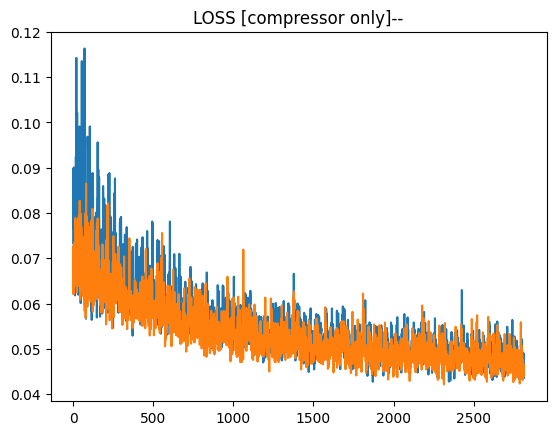

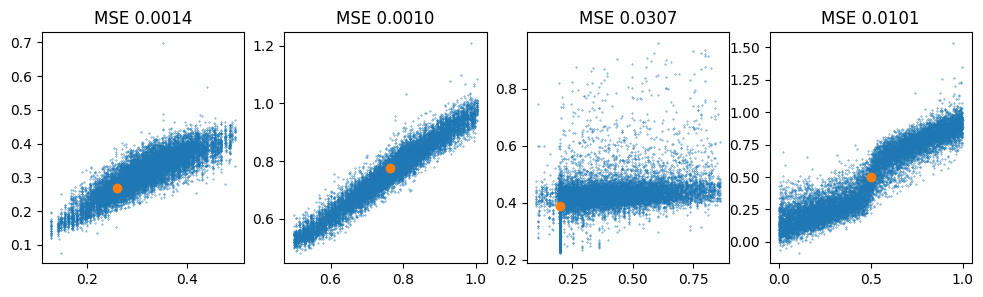

In [58]:
'''
Let's train first only the compression part using a MSE loss
'''

rng_seq = hk.PRNGSequence(42)

model_compressor = hk.without_apply_rng(hk.transform(lambda x: Compressor()(x)))
optimizer = optax.chain(optax.adam(1e-4))
params_compressor = model_compressor.init(next(rng_seq), jnp.zeros([1, len_dv]))
opt_state = optimizer.init(params_compressor)


def average_loss(params, rng_key, batches):
    total_loss = 0.0
    for batch in batches:
        x, y = batch
        z = model_compressor.apply(params, y)
        total_loss += jnp.mean(weights_loss_MSE*((z - x) ** 2))
    return total_loss / len(batches)

@jax.jit
def update_mse(params, rng_key, opt_state, batches):
    """Single SGD update step using MSE loss averaged over multiple batches."""
    loss = average_loss(params, rng_key, batches)
    grads = jax.grad(lambda p: average_loss(p, rng_key, batches))(params)
    updates, new_opt_state = optimizer.update(grads, opt_state)
    new_params = optax.apply_updates(params, updates)
    return loss, new_params, new_opt_state

@jax.jit
def validate_model_mse(params, batches, rng_key):
    """Validate the model using MSE loss averaged over multiple batches."""
    val_loss = average_loss(params, rng_key, batches)
    return val_loss

def get_batches(iterator, num_batches):
    return [next(iterator) for _ in range(num_batches)]



losses = []
val_losses = []
no_improve_count = 0
no_improve_threshold = 500  # Set X to the number of iterations you'll allow without any decrease in loss
best_loss = float('inf')
best_params_compressor = None  # Initialize a variable to store the best parameters

NUM_BATCHES = 5  # Number of batches to average over

for epoch in frogress.bar(range(100000)):
    training_batches = get_batches(dset, NUM_BATCHES)
    loss, params_compressor, opt_state = update_mse(params_compressor, next(rng_seq), opt_state, training_batches)
    
    validation_batches = get_batches(dset_y_val, NUM_BATCHES)
    val_loss = validate_model_mse(params_compressor, validation_batches, next(rng_seq))
    
    losses.append(loss)
    val_losses.append(val_loss)

    if val_loss < best_loss:
        best_loss = val_loss
        no_improve_count = 0
        best_params_compressor = copy.deepcopy(params_compressor)
    else:
        no_improve_count += 1

    if no_improve_count >= no_improve_threshold:
        print(f"Stopping early due to no decrease in loss after {no_improve_threshold} iterations.")
        break


print ('BEST LOSS ',best_loss)


z_LFI = model_compressor.apply(best_params_compressor, dv_LFI) 
z_target = model_compressor.apply(best_params_compressor, np.array(dv_target).reshape(1,-1))
z_target = z_target[0]

plt.title('LOSS [compressor only]--')
plt.plot(losses[500:])
plt.plot(val_losses[500:])
#plt.ylim([-10,2])
plt.show()


MSE = np.mean((z_LFI[:,0]-pars_LFI[:,0])**2)
MSE1 = np.mean((z_LFI[:,1]-pars_LFI[:,1])**2)
MSE2 = np.mean((z_LFI[:,2]-pars_LFI[:,2])**2)
MSE3 = np.mean((z_LFI[:,3]-pars_LFI[:,3])**2)

fig, ax = plt.subplots(1,4,sharex=False,sharey=False, figsize=(12,3)) 
ax[0].scatter(pars_LFI[:,0],z_LFI[:,0],s=0.1)
ax[0].scatter([0.26],[z_target[0]])
ax[0].set_title('MSE {0:2.4f}'.format(MSE))
ax[1].set_title('MSE {0:2.4f}'.format(MSE1))
ax[1].scatter(pars_LFI[:,1],z_LFI[:,1],s=0.1)
ax[1].scatter([0.82*np.sqrt(0.26/0.3)],[z_target[1]])
ax[2].set_title('MSE {0:2.4f}'.format(MSE2))
ax[2].scatter(pars_LFI[:,2],z_LFI[:,2],s=0.1)
ax[2].scatter([-1.+1.2],[z_target[2]])
ax[3].set_title('MSE {0:2.4f}'.format(MSE3))
ax[3].scatter(pars_LFI[:,3],z_LFI[:,3],s=0.1)
ax[3].scatter([0.5],[z_target[3]])
plt.show()


In [23]:
'''
Let's train the NDEs only, using the best parameters for the compression part using
the mutual information loss
'''

rng_seq = hrng_seq = hk.PRNGSequence(42)
model_logp = hk.without_apply_rng(hk.transform(lambda x,y : AffineFlow()().log_prob(x,bijector_kwargs={'nvp%d'%i:{'cond':y} for i in range(4)})))
params_flow = model_logp.init(next(rng_seq), jnp.zeros([1, number_of_params]), jnp.zeros([1, number_of_params]))

optimizer = optax.chain(optax.adam(1e-4))
opt_state = optimizer.init(params_flow)


def average_loss(params, rng_key, batches, best_params_compressor):
    total_loss = 0.0
    for batch in batches:
        x, y = batch
        z = model_compressor.apply(best_params_compressor, y)
        logp = model_logp.apply(params, x, z)
        total_loss += -jnp.mean(logp)
    return total_loss / len(batches)

@jax.jit
def update(params, rng_key, opt_state, batches):
    """Single SGD update step averaged over multiple batches."""
    loss = average_loss(params, rng_key, batches, best_params_compressor)
    grads = jax.grad(lambda p: average_loss(p, rng_key, batches, best_params_compressor))(params)
    updates, new_opt_state = optimizer.update(grads, opt_state)
    new_params = optax.apply_updates(params, updates)
    return loss, new_params, new_opt_state

@jax.jit
def validate_model(params, batches, rng_key):
    """Validate the model using average loss over multiple batches."""
    val_loss = average_loss(params, rng_key, batches, best_params_compressor)
    return val_loss

def get_batches(iterator, num_batches):
    return [next(iterator) for _ in range(num_batches)]

# Training loop
NUM_BATCHES = 5  # Number of batches to average over
losses = []
val_losses = []
no_improve_count = 0
no_improve_threshold = 500
best_loss = float('inf')
best_params_flow = None

for s in frogress.bar(range(100000)):
    training_batches = get_batches(dset, NUM_BATCHES)
    loss, params_flow, opt_state = update(params_flow, next(rng_seq), opt_state, training_batches)
    
    validation_batches = get_batches(dset_y_val, NUM_BATCHES)
    val_loss = validate_model(params_flow, validation_batches, next(rng_seq))
    
    losses.append(loss)
    val_losses.append(val_loss)

    if val_loss < best_loss:
        best_loss = val_loss
        no_improve_count = 0
        best_params_flow = copy.deepcopy(params_flow)
    else:
        no_improve_count += 1

    if no_improve_count >= no_improve_threshold:
        print(f"Stopping early at step {s} due to no decrease in loss after {no_improve_threshold} iterations.")
        break
print ('BEST LOSS ',best_loss)
    
plt.title('LOSS')
plt.plot(losses[500:])
plt.plot(val_losses[500:])
#plt.ylim([-10,2])
plt.show()


  3.0% | [..........] | Progress: 3000 / 100000 | Time: 4min13s | ETA: 2h16min12s

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



In [ ]:
'''
Let's train the compression+NDEs together, using the best parameters from the previous two steps as a starting point
'''

rng_seq = hk.PRNGSequence(42)

model_compressor = hk.without_apply_rng(hk.transform(lambda x: Compressor()(x)))
model_logp = hk.without_apply_rng(hk.transform(lambda x,y : AffineFlow()().log_prob(x,bijector_kwargs={'nvp%d'%i:{'cond':y} for i in range(4)})))
model_sample = hk.transform(lambda n,y : AffineFlow()().sample(n, seed=hk.next_rng_key(), bijector_kwargs={'nvp%d'%i:{'cond':y} for i in range(4)}))

# copying this from before ~ ------------
params_compressor = copy.deepcopy(best_params_compressor)
params_flow = copy.deepcopy(best_params_flow)
params = hk.data_structures.merge(params_flow, params_compressor)


optimizer = optax.chain(optax.adam(1e-5))
opt_state = optimizer.init(params)


def average_loss(params, rng_key, batches):
    total_loss = 0.0
    for batch in batches:
        x, y = batch
        z = model_compressor.apply(params, y)  # Assuming you're using some pre-trained parameters or another method here
        logp = model_logp.apply(params, x, z)
        total_loss += -jnp.mean(logp)
        
    total_loss_mse = 0.0
    for batch in batches:
        x, y = batch
        z = model_compressor.apply(params, y)
        total_loss_mse += jnp.mean(weights_loss_MSE*((z - x) ** 2))
        
    avg_loss = (5*np.log(total_loss)+total_loss_mse)/len(batches)
    return avg_loss

@jax.jit
def update(params, rng_key, opt_state, batches):
    """Single SGD update step averaged over multiple batches."""
    loss = average_loss(params, rng_key, batches)
    grads = jax.grad(lambda p: average_loss(p, rng_key, batches))(params)
    updates, new_opt_state = optimizer.update(grads, opt_state)
    new_params = optax.apply_updates(params, updates)
    return loss, new_params, new_opt_state

@jax.jit
def validate_model(params, batches, rng_key):
    """Validate the model using average loss over multiple batches."""
    val_loss = average_loss(params, rng_key, batches)
    return val_loss

def get_batches(iterator, num_batches):
    return [next(iterator) for _ in range(num_batches)]

# Training loop adjustments
NUM_BATCHES = 30  # Number of batches to average over
losses = []
val_losses = []
no_improve_count = 0
no_improve_threshold = 500
best_loss = float('inf')
best_params = None

for s in frogress.bar(range(100000)):
    training_batches = get_batches(dset, NUM_BATCHES)
    loss, params, opt_state = update(params, next(rng_seq), opt_state, training_batches)
    
    validation_batches = get_batches(dset_y_val, NUM_BATCHES)
    val_loss = validate_model(params, validation_batches, next(rng_seq))
    
    losses.append(loss)
    val_losses.append(val_loss)

    if val_loss < best_loss:
        best_loss = val_loss
        no_improve_count = 0
        best_params = copy.deepcopy(params)
    else:
        no_improve_count += 1

    if no_improve_count >= no_improve_threshold:
        print(f"Stopping early at step {s} due to no decrease in loss after {no_improve_threshold} iterations.")
        break

print('BEST LOSS', best_loss)
# predict ------
batch = next(dset)
x,y = batch

z_LFI = model_sample.apply(best_params, next(rng_seq), n=dv_LFI.shape[0], y=model_compressor.apply(best_params, dv_LFI))
z_target = model_sample.apply(best_params, next(rng_seq), n=1, y=model_compressor.apply(best_params, np.array(dv_target).reshape(1,-1)))
z_target = z_target[0]



  0.0% | [..........] | Progress: 1 / 100000 | Time: 0.0s | ETA: 10.3sTraced<ShapedArray(float32[])>with<DynamicJaxprTrace(level=1/0)> Traced<ShapedArray(float32[])>with<DynamicJaxprTrace(level=1/0)>
Traced<ShapedArray(float32[])>with<JVPTrace(level=3/0)> with
  primal = Traced<ShapedArray(float32[])>with<DynamicJaxprTrace(level=1/0)>
  tangent = Traced<ShapedArray(float32[])>with<JaxprTrace(level=2/0)> with
    pval = (ShapedArray(float32[]), None)
    recipe = JaxprEqnRecipe(eqn_id=<object object at 0x7f64b0332bc0>, in_tracers=(Traced<ShapedArray(float32[]):JaxprTrace(level=2/0)>, Traced<ShapedArray(float32[]):JaxprTrace(level=2/0)>), out_tracer_refs=[<weakref at 0x7f64b00cbef0; to 'JaxprTracer' at 0x7f64904403b0>], out_avals=[ShapedArray(float32[])], primitive=pjit, params={'jaxpr': { lambda ; a:f32[] b:f32[]. let c:f32[] = add a b in (c,) }, 'in_shardings': (UnspecifiedValue, UnspecifiedValue), 'out_shardings': (UnspecifiedValue,), 'resource_env': None, 'donated_invars': (False, Fa

In [ ]:
plt.title('LOSS')
plt.plot(np.array(losses[:]))
plt.plot(np.array(val_losses[:]))
#plt.ylim([-10,2])
plt.show()

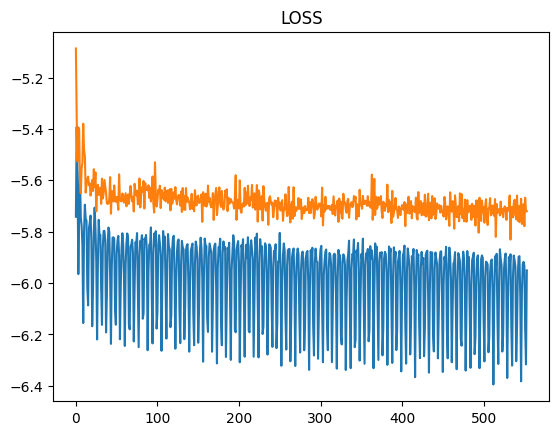

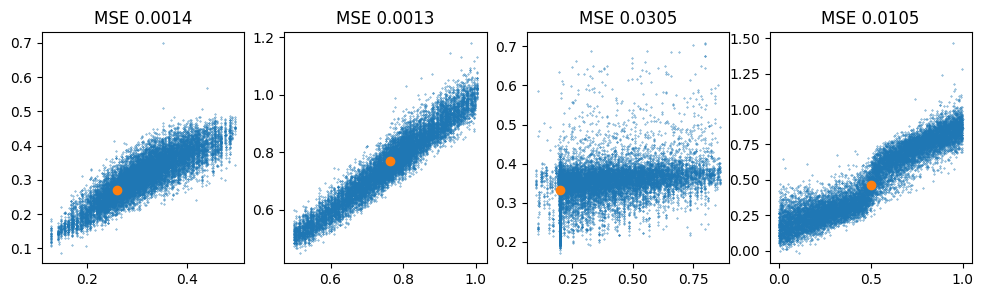

In [46]:
# predict ------
batch = next(dset)
x,y = batch

z_LFI = model_compressor.apply(best_params, dv_LFI)
z_target = model_compressor.apply(best_params, np.array(dv_target).reshape(1,-1))

#z_LFI = model_compressor.apply(best_params_compressor, dv_LFI)
#z_target = model_compressor.apply(best_params_compressor, np.array(dv_target).reshape(1,-1))

z_target = z_target[0]


plt.title('LOSS')
plt.plot(losses)
plt.plot(val_losses)
#plt.ylim([-10,2])
plt.show()


MSE = np.mean((z_LFI[:,0]-pars_LFI[:,0])**2)
MSE1 = np.mean((z_LFI[:,1]-pars_LFI[:,1])**2)
MSE2 = np.mean((z_LFI[:,2]-pars_LFI[:,2])**2)
MSE3 = np.mean((z_LFI[:,3]-pars_LFI[:,3])**2)

fig, ax = plt.subplots(1,4,sharex=False,sharey=False, figsize=(12,3)) 
ax[0].scatter(pars_LFI[:,0],z_LFI[:,0],s=0.1)
ax[0].scatter([0.26],[z_target[0]])
ax[0].set_title('MSE {0:2.4f}'.format(MSE))
ax[1].set_title('MSE {0:2.4f}'.format(MSE1))
ax[1].scatter(pars_LFI[:,1],z_LFI[:,1],s=0.1)
ax[1].scatter([0.82*np.sqrt(0.26/0.3)],[z_target[1]])
ax[2].set_title('MSE {0:2.4f}'.format(MSE2))
ax[2].scatter(pars_LFI[:,2],z_LFI[:,2],s=0.1)
ax[2].scatter([-1.+1.2],[z_target[2]])
ax[3].set_title('MSE {0:2.4f}'.format(MSE3))
ax[3].scatter(pars_LFI[:,3],z_LFI[:,3],s=0.1)
ax[3].scatter([0.5],[z_target[3]])
plt.show()



compressed_DV_VMIM = dict()  
compressed_DV_VMIM[statistic] = dict()
compressed_DV_VMIM[statistic]['params'] = np.array(pars_LFI)
compressed_DV_VMIM[statistic]['DV'] =  np.array(z_LFI)
compressed_DV_VMIM[statistic]['target'] =  np.array(z_target)

In [197]:
best_loss

Array(-6.2265654, dtype=float32)

In [ ]:
4p + splitting :
0.0025 0.0015

4p:
0.0031 0.0020

2p:
0.0025 / 0.0013

In [ ]:
# try to increase the batch size here and in NN and see what changes ----------
# I'd suggest to use back the 128 batch size and simply compute the loss function multiple times and get an average.


# NN

In [56]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Concatenate
from tensorflow.keras.layers import Dense, Dropout, LeakyReLU, ReLU
from tensorflow.keras.optimizers import Adam
import tensorflow as tf
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.layers import Input, Add
from tensorflow.keras.callbacks import EarlyStopping



def simple_model_2d_2k(input_size, lr=1e-4):
    # create model
    model = Sequential()
    model.add(Dense(1900, input_dim=input_size, kernel_initializer='normal'))
    model.add(LeakyReLU(alpha=0.01))
    model.add(Dense(1500, input_dim=input_size, kernel_initializer='normal'))
    model.add(LeakyReLU(alpha=0.01))
    model.add(Dense(900, input_dim=input_size, kernel_initializer='normal'))
    model.add(LeakyReLU(alpha=0.01))
    model.add(Dense(500, input_dim=input_size, kernel_initializer='normal'))
    model.add(LeakyReLU(alpha=0.01))
    model.add(Dense(100, input_dim=input_size, kernel_initializer='normal'))
    model.add(ReLU())
    model.add(Dense(100, input_dim=input_size, kernel_initializer='normal'))
    model.add(ReLU())
    model.add(Dense(1, kernel_initializer='normal'))

    model.compile(optimizer=Adam(lr=lr), loss='mse')
    return model


def simple_model_2d_1k(input_size, lr=1e-4):
    # create model
    model = Sequential()
    model.add(Dense(900, input_dim=input_size, kernel_initializer='normal'))
    model.add(LeakyReLU(alpha=0.01))
    model.add(Dense(800, input_dim=input_size, kernel_initializer='normal'))
    model.add(LeakyReLU(alpha=0.01))
    # model.add(ReLU())
    model.add(Dense(100, input_dim=input_size, kernel_initializer='normal'))
    # model.add(LeakyReLU(alpha=0.01))
    model.add(ReLU())
    model.add(Dense(100, input_dim=input_size, kernel_initializer='normal'))
    # model.add(LeakyReLU(alpha=0.01))
    model.add(ReLU())
    # model.add(ReLU())
    model.add(Dense(1, kernel_initializer='normal'))

    #model.compile(optimizer=Adam(lr=lr), loss='mse')#loss='mean_absolute_error')#loss='mse')
    model.compile(optimizer=Adam(lr=lr), loss='mse')#loss='mse')
    return model



def simple_model_2d_400(input_size, lr=1e-4):
    # create model
    model = Sequential()
    model.add(Dense(400, input_dim=input_size, kernel_initializer='normal'))
    model.add(LeakyReLU(alpha=0.01))
    model.add(Dense(300, input_dim=input_size, kernel_initializer='normal'))
    model.add(LeakyReLU(alpha=0.01))
    # model.add(ReLU())
    model.add(Dense(100, input_dim=input_size, kernel_initializer='normal'))
    # model.add(LeakyReLU(alpha=0.01))
    model.add(ReLU())
    model.add(Dense(50, input_dim=input_size, kernel_initializer='normal'))
    # model.add(LeakyReLU(alpha=0.01))
    model.add(ReLU())
    # model.add(ReLU())
    model.add(Dense(1, kernel_initializer='normal'))

    model.compile(optimizer=Adam(lr=lr), loss='mse')#loss='mean_absolute_error')#loss='mse')
    return model


In [57]:
compressed_DV_NN = dict()
compressed_DV_NN[statistic] = dict()

parameters = ['Om','S8','w','A']

for i, parameter in enumerate(parameters):
    if parameter == 'Om':
        mask_parameter = np.array([True,False,False,False])[:number_of_params]
    if parameter == 'S8':
        mask_parameter = np.array([False,True,False,False])[:number_of_params]
    if parameter == 'w':
        mask_parameter = np.array([False,False,True,False])[:number_of_params]
    if parameter == 'A':
        mask_parameter = np.array([False,False,False,True])[:number_of_params]


    regression_power = simple_model_2d_1k(len_dv, lr=1e-5)


    iter_ = 1
    early_stopping = EarlyStopping(monitor='val_loss', patience=15, verbose=1, mode='min', restore_best_weights=True)

    for round_ in range(iter_):
        print ('ROUND ', round_)
        
        numerical_noise = 0.*np.random.normal(np.array(dv_train)*0.,2e-3)
        history_2d_power = regression_power.fit((np.array(dv_train)+numerical_noise),
                   np.array(pars_train)[:,mask_parameter],
                   epochs =150,batch_size = 32, shuffle=True,
                   validation_data = ((np.array(dv_val)[:,:]),
                                      np.array(pars_val)[:,mask_parameter]),callbacks=[early_stopping])
        
        
    # Check if early stopping was triggered
        if early_stopping.stopped_epoch > 0:
            print(f"Early stopping triggered at round {round_}, stopping further training.")
            break  # Exit the loop, skipping subsequent rounds


    #regression_power.save_weights((output_folder+'/compression_models/'+statistic+'_'+parameter))

    compressed_data_v  = np.clip(regression_power.predict( np.array(dv_LFI)), -1., 1.5)
    compressed_data_target  = np.clip(regression_power.predict( np.array(dv_target).reshape(1,-1)), -1., 1.5)[0][0]




    if i == 0 :
        compressed_DV_NN[statistic]['params'] = np.array(pars_LFI[:,mask_parameter])[:,0]
        compressed_DV_NN[statistic]['DV'] = compressed_data_v[:,0]
        compressed_DV_NN[statistic]['target'] = compressed_data_target
    else:
        compressed_DV_NN[statistic]['params'] = np.vstack([compressed_DV_NN[statistic]['params'],np.array(pars_LFI[:,mask_parameter])[:,0]])
        compressed_DV_NN[statistic]['DV'] = np.vstack([compressed_DV_NN[statistic]['DV'],compressed_data_v[:,0]])
        compressed_DV_NN[statistic]['target'] = np.vstack([compressed_DV_NN[statistic]['target'],compressed_data_target])


compressed_DV_NN[statistic]['DV'] = compressed_DV_NN[statistic]['DV'].T
compressed_DV_NN[statistic]['params'] = compressed_DV_NN[statistic]['params'].T
compressed_DV_NN[statistic]['target'] = compressed_DV_NN[statistic]['target'].T[0]

ROUND  0
Epoch 1/150
679/679 [==============================] - 4s 5ms/step - loss: 0.0539 - val_loss: 0.0412
Epoch 2/150
679/679 [==============================] - 3s 5ms/step - loss: 0.0374 - val_loss: 0.0356
Epoch 3/150
679/679 [==============================] - 3s 5ms/step - loss: 0.0356 - val_loss: 0.0326
Epoch 4/150
679/679 [==============================] - 3s 5ms/step - loss: 0.0346 - val_loss: 0.0452
Epoch 5/150
679/679 [==============================] - 3s 5ms/step - loss: 0.0342 - val_loss: 0.0326
Epoch 6/150
679/679 [==============================] - 3s 5ms/step - loss: 0.0335 - val_loss: 0.0359
Epoch 7/150
679/679 [==============================] - 3s 5ms/step - loss: 0.0332 - val_loss: 0.0328
Epoch 8/150
679/679 [==============================] - 3s 5ms/step - loss: 0.0330 - val_loss: 0.0326
Epoch 9/150
679/679 [==============================] - 3s 5ms/step - loss: 0.0330 - val_loss: 0.0315
Epoch 10/150
679/679 [==============================] - 3s 5ms/step - loss: 0.0330

ROUND  0
Epoch 1/150
679/679 [==============================] - 4s 5ms/step - loss: 0.0553 - val_loss: 0.0347
Epoch 2/150
679/679 [==============================] - 3s 5ms/step - loss: 0.0381 - val_loss: 0.0311
Epoch 3/150
679/679 [==============================] - 3s 5ms/step - loss: 0.0343 - val_loss: 0.0305
Epoch 4/150
679/679 [==============================] - 3s 5ms/step - loss: 0.0325 - val_loss: 0.0291
Epoch 5/150
679/679 [==============================] - 3s 5ms/step - loss: 0.0314 - val_loss: 0.0317
Epoch 6/150
679/679 [==============================] - 3s 5ms/step - loss: 0.0313 - val_loss: 0.0280
Epoch 7/150
679/679 [==============================] - 3s 5ms/step - loss: 0.0302 - val_loss: 0.0278
Epoch 8/150
679/679 [==============================] - 3s 5ms/step - loss: 0.0307 - val_loss: 0.0308
Epoch 9/150
679/679 [==============================] - 3s 5ms/step - loss: 0.0291 - val_loss: 0.0286
Epoch 10/150
679/679 [==============================] - 3s 5ms/step - loss: 0.0291

ROUND  0
Epoch 1/150
679/679 [==============================] - 4s 5ms/step - loss: 0.1432 - val_loss: 0.1464
Epoch 2/150
679/679 [==============================] - 3s 5ms/step - loss: 0.1369 - val_loss: 0.1325
Epoch 3/150
679/679 [==============================] - 3s 5ms/step - loss: 0.1346 - val_loss: 0.1348
Epoch 4/150
679/679 [==============================] - 3s 5ms/step - loss: 0.1328 - val_loss: 0.1298
Epoch 5/150
679/679 [==============================] - 4s 5ms/step - loss: 0.1317 - val_loss: 0.1271
Epoch 6/150
679/679 [==============================] - 3s 5ms/step - loss: 0.1302 - val_loss: 0.1261
Epoch 7/150
679/679 [==============================] - 3s 5ms/step - loss: 0.1300 - val_loss: 0.1342
Epoch 8/150
679/679 [==============================] - 3s 5ms/step - loss: 0.1298 - val_loss: 0.1253
Epoch 9/150
679/679 [==============================] - 3s 5ms/step - loss: 0.1290 - val_loss: 0.1252
Epoch 10/150
679/679 [==============================] - 3s 5ms/step - loss: 0.1279

ROUND  0
Epoch 1/150
679/679 [==============================] - 4s 5ms/step - loss: 0.1488 - val_loss: 0.1103
Epoch 2/150
679/679 [==============================] - 3s 5ms/step - loss: 0.1167 - val_loss: 0.1175
Epoch 3/150
679/679 [==============================] - 3s 5ms/step - loss: 0.1125 - val_loss: 0.0990
Epoch 4/150
679/679 [==============================] - 3s 5ms/step - loss: 0.1088 - val_loss: 0.1028
Epoch 5/150
679/679 [==============================] - 3s 5ms/step - loss: 0.1060 - val_loss: 0.1038
Epoch 6/150
679/679 [==============================] - 3s 5ms/step - loss: 0.1056 - val_loss: 0.0964
Epoch 7/150
679/679 [==============================] - 3s 5ms/step - loss: 0.1044 - val_loss: 0.1184
Epoch 8/150
679/679 [==============================] - 3s 5ms/step - loss: 0.1022 - val_loss: 0.1066
Epoch 9/150
679/679 [==============================] - 3s 5ms/step - loss: 0.1023 - val_loss: 0.1026
Epoch 10/150
679/679 [==============================] - 3s 5ms/step - loss: 0.1007

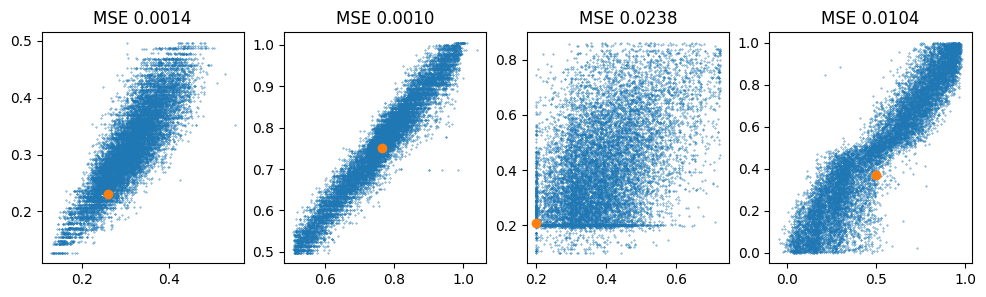

In [59]:
MSE = np.mean((compressed_DV_NN[statistic]['DV'][:,0]-compressed_DV_NN[statistic]['params'][:,0])**2)
MSE1 = np.mean((compressed_DV_NN[statistic]['DV'][:,1]-compressed_DV_NN[statistic]['params'][:,1])**2)
MSE2 = np.mean((compressed_DV_NN[statistic]['DV'][:,2]-compressed_DV_NN[statistic]['params'][:,2])**2)
MSE3 = np.mean((compressed_DV_NN[statistic]['DV'][:,3]-compressed_DV_NN[statistic]['params'][:,3])**2)

fig, ax = plt.subplots(1,4,sharex=False,sharey=False, figsize=(12,3)) 


#fig, ax = plt.subplots(1,2,sharex=False,sharey=False, figsize=(7,3)) 
ax[0].scatter(compressed_DV_NN[statistic]['DV'][:,0],compressed_DV_NN[statistic]['params'][:,0],s=0.1)
ax[0].scatter([0.26],[z_target[0]])
ax[0].set_title('MSE {0:2.4f}'.format(MSE))
ax[1].scatter(compressed_DV_NN[statistic]['DV'][:,1],compressed_DV_NN[statistic]['params'][:,1],s=0.1)
ax[1].scatter([0.82*np.sqrt(0.26/0.3)],[z_target[1]])
ax[1].set_title('MSE {0:2.4f}'.format(MSE1))

ax[2].scatter(compressed_DV_NN[statistic]['DV'][:,2],compressed_DV_NN[statistic]['params'][:,2],s=0.1)
ax[2].scatter([-1+1.2],[z_target[2]])
ax[2].set_title('MSE {0:2.4f}'.format(MSE2))

ax[3].scatter(compressed_DV_NN[statistic]['DV'][:,3],compressed_DV_NN[statistic]['params'][:,3],s=0.1)
ax[3].scatter([0.5],[z_target[3]])
ax[3].set_title('MSE {0:2.4f}'.format(MSE3))
plt.show()


In [54]:
1000000000000000---------------------------------------

1

In [ ]:

# Less training (12k), with early stoppage, simple model
0.0014,0.0009,0.0222,0.0119

# More training (21k), with early stoppage, simple model
0.0013,0.0009,0.0231,0.0102

# More training (21k), with early stoppage, complex model
0.0014,0.0009,0.0281,0.0116

# More training (21k), with early stoppage, extra simple model
0.0015,0.0009,0.0227,0.0100

# More training (21k), with early stoppage, simple model, L1
0.0014,0.0010,0.0238,0.0104

# I can try to let it run more to see if there's any improvement

# or even to use a slightly simpler architecture

# NN2

In [66]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, LeakyReLU, ReLU, Input, Concatenate
from tensorflow.keras.optimizers import Adam

def create_branch(input_shape):
    # Input layer for the branch
    inputs = Input(shape=(input_shape,))
    # First dense layer
    x = Dense(900, kernel_initializer='normal')(inputs)
    x = LeakyReLU(alpha=0.01)(x)
    # Second dense layer
    x = Dense(800, kernel_initializer='normal')(x)
    x = LeakyReLU(alpha=0.01)(x)
    # Third dense layer
    x = Dense(100, kernel_initializer='normal')(x)
    x = ReLU()(x)
    # Fourth dense layer
    x = Dense(100, kernel_initializer='normal')(x)
    x = ReLU()(x)
    # Output layer for the branch
    output = Dense(1, kernel_initializer='normal')(x)
    return Model(inputs=inputs, outputs=output)

def create_combined_model(input_size, lr=1e-4, num_branches=4):
    # Create input layer
    inputs = Input(shape=(input_size,))
    # Create branches
    branches = [create_branch(input_size) for _ in range(num_branches)]
    # Get the output of each branch
    branch_outputs = [branch(inputs) for branch in branches]
    # Concatenate all branch outputs
    concatenated = Concatenate()(branch_outputs)
    # Create combined model
    model = Model(inputs=inputs, outputs=concatenated)
    # Compile the model
    model.compile(optimizer=Adam(lr=lr), loss='mse')
    return model

In [67]:
compressed_DV_NN2 = dict()
compressed_DV_NN2[statistic] = dict()



regression_power = create_combined_model(len_dv, lr=1e-5,num_branches=number_of_params)


iter_ = 1
early_stopping = EarlyStopping(monitor='val_loss', patience=15, verbose=1, mode='min', restore_best_weights=True)

for round_ in range(iter_):
    print ('ROUND ', round_)

    numerical_noise = 0.*np.random.normal(np.array(dv_train)*0.,2e-3)
    history_2d_power = regression_power.fit((np.array(dv_train)+numerical_noise),
               np.array(pars_train)[:,:],
               epochs =150,batch_size = 32, shuffle=True,
               validation_data = ((np.array(dv_val)[:,:]),
                                  np.array(pars_val)[:,:]),callbacks=[early_stopping])


# Check if early stopping was triggered
    if early_stopping.stopped_epoch > 0:
        print(f"Early stopping triggered at round {round_}, stopping further training.")
        break  # Exit the loop, skipping subsequent rounds


#regression_power.save_weights((output_folder+'/compression_models/'+statistic+'_'+parameter))

compressed_data_v  = np.clip(regression_power.predict( np.array(dv_LFI)), -1., 1.5)
compressed_data_target  = np.clip(regression_power.predict( np.array(dv_target).reshape(1,-1)), -1., 1.5)[0][0]




compressed_DV_NN2[statistic]['params'] = np.array(pars_LFI[:,:])
compressed_DV_NN2[statistic]['DV'] = compressed_data_v
compressed_DV_NN2[statistic]['target'] = compressed_data_target


ROUND  0
Epoch 1/150
679/679 [==============================] - 13s 16ms/step - loss: 0.0200 - val_loss: 0.0122
Epoch 2/150
679/679 [==============================] - 10s 15ms/step - loss: 0.0128 - val_loss: 0.0120
Epoch 3/150
679/679 [==============================] - 10s 15ms/step - loss: 0.0125 - val_loss: 0.0119
Epoch 4/150
679/679 [==============================] - 10s 15ms/step - loss: 0.0121 - val_loss: 0.0108
Epoch 5/150
679/679 [==============================] - 10s 15ms/step - loss: 0.0118 - val_loss: 0.0122
Epoch 6/150
679/679 [==============================] - 10s 15ms/step - loss: 0.0116 - val_loss: 0.0113
Epoch 7/150
679/679 [==============================] - 10s 15ms/step - loss: 0.0114 - val_loss: 0.0117
Epoch 8/150
679/679 [==============================] - 10s 15ms/step - loss: 0.0112 - val_loss: 0.0108
Epoch 9/150
679/679 [==============================] - 10s 15ms/step - loss: 0.0113 - val_loss: 0.0109
Epoch 10/150
679/679 [==============================] - 10s 15ms

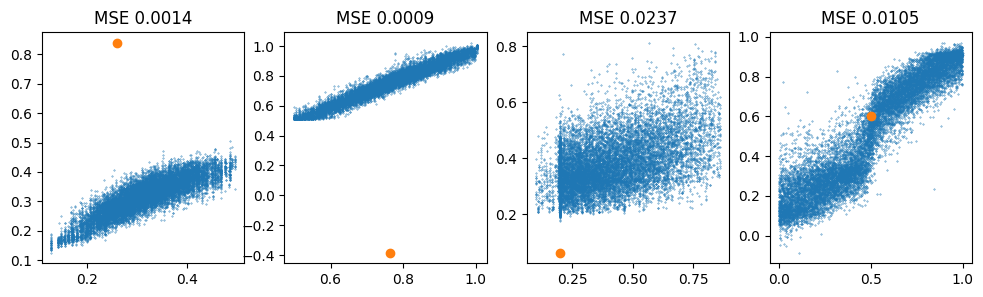

In [124]:
MSE = np.mean((compressed_DV_NN2[statistic]['DV'][:,0]-compressed_DV_NN2[statistic]['params'][:,0])**2)
MSE1 = np.mean((compressed_DV_NN2[statistic]['DV'][:,1]-compressed_DV_NN2[statistic]['params'][:,1])**2)
MSE2 = np.mean((compressed_DV_NN2[statistic]['DV'][:,2]-compressed_DV_NN2[statistic]['params'][:,2])**2)
MSE3 = np.mean((compressed_DV_NN2[statistic]['DV'][:,3]-compressed_DV_NN2[statistic]['params'][:,3])**2)

fig, ax = plt.subplots(1,4,sharex=False,sharey=False, figsize=(12,3)) 


#fig, ax = plt.subplots(1,2,sharex=False,sharey=False, figsize=(7,3)) 
ax[0].scatter(compressed_DV_NN2[statistic]['params'][:,0],compressed_DV_NN2[statistic]['DV'][:,0],s=0.1)
ax[0].scatter([0.26],[z_target[0]])
ax[0].set_title('MSE {0:2.4f}'.format(MSE))
ax[1].scatter(compressed_DV_NN2[statistic]['params'][:,1],compressed_DV_NN2[statistic]['DV'][:,1],s=0.1)
ax[1].scatter([0.82*np.sqrt(0.26/0.3)],[z_target[1]])
ax[1].set_title('MSE {0:2.4f}'.format(MSE1))

ax[2].scatter(compressed_DV_NN2[statistic]['params'][:,2],compressed_DV_NN2[statistic]['DV'][:,2],s=0.1)
ax[2].scatter([-1+1.2],[z_target[2]])
ax[2].set_title('MSE {0:2.4f}'.format(MSE2))

ax[3].scatter(compressed_DV_NN2[statistic]['params'][:,3],compressed_DV_NN2[statistic]['DV'][:,3],s=0.1)
ax[3].scatter([0.5],[z_target[3]])
ax[3].set_title('MSE {0:2.4f}'.format(MSE3))
plt.show()


# MOPED

# IMNN

In [ ]:
import jax
import jax.numpy as jnp
from jax import random
from jax.experimental import stax, optimizers
from jax.experimental.stax import Dense, Relu, LeakyRelu, Concatenate
import imnn
import imnn.lfi
import tensorflow_probability as tfp
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
from functools import partial

tfp = tensorflow_probability.substrates.jax
rng = jax.random.PRNGKey(0)



# MODEL -------

def CustomBranch(negative_slope=0.01):
    # Define a single branch of the model
    return stax.serial(
        Dense(900), LeakyRelu(negative_slope),
        Dense(800), LeakyRelu(negative_slope),
        Dense(100), Relu,
        Dense(100), Relu,
        Dense(1)  # Output layer for each branch
    )

def MyModel(number_of_branches=number_of_params):
    # Create multiple branches and concatenate their outputs
    branches = [CustomBranch() for _ in range(number_of_branches)]
    # Using FanOut and FanInSum to parallelize branches and then concatenate outputs
    return stax.serial(
        stax.FanOut(number_of_branches),
        stax.parallel(*branches),
        stax.FanInConcat(axis=-1)
    )


In [147]:
np.save('resume3',[compressed_DV_VMIM,compressed_DV_NN])

In [13]:
np.save('resume_simpler_less2_L1',[compressed_DV_VMIM,compressed_DV_NN])

# LFI

Need to load another environment for this...

In [4]:
%matplotlib inline
import matplotlib.pyplot as plt

import sys
sys.path.insert(0, "/global/cfs/cdirs/des/mgatti/tensorflow_115/")
import pydelfi.priors as priors
import tensorflow as tf
import pydelfi.ndes as ndes
import pydelfi.delfi as delfi
import emcee as mc
import numpy as np
theta2d_expected_mean = [ 0.75,0.3,0.5,0.5]

def initial_parameters(theta, relative_sigma):
    """
    This is not randomise the initial position of the
    :param theta: list/a
    rray of parameter values
    :param relative_sigma: controls variance of random draws
    :return: the theta array but with random shifts
    """
    theta = np.array(theta)
    return np.random.normal(theta, np.abs(theta * relative_sigma))

result_dir = '../../../../../../../pscratch/sd/m/mgatti/temp2/'       

lower = np.array([0.15, 0.55,0.15,0])
upper = np.array([0.49, 0.99,0.85,1])
    
lower_mc = np.array([0.15, 0.55,0.2,0])
upper_mc = np.array([0.49, 0.99,0.85,1])
    
prior = priors.Uniform(lower, upper)


/global/homes/m/mgatti/.conda/envs/bfd_env3/lib/python3.6/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [5]:
import numpy as np
[compressed_DV_VMIM,compressed_DV_NN] = np.load('resume_simpler.npy',allow_pickle=True)#.item()

In [6]:
compressed_dict = dict()
compressed_dict['VMIM'] = compressed_DV_VMIM
compressed_dict['NN'] = compressed_DV_NN

In [7]:
DelfiEnsemble_dict = dict()


statistic = 'WL_2'

count = 11
for key in compressed_dict.keys():

    nn = len(lower)
    base = count # any time you re-run it, please increase this by the number of NDEs. Otherwise you'd need to restart the notebook.
    count += 4
    NDEs = [ndes.ConditionalMaskedAutoregressiveFlow(n_parameters=nn, n_data=compressed_dict[key][statistic]['DV'].shape[1], n_hiddens=[60,60], n_mades=4, act_fun=tf.tanh, index=base + 0),
            ndes.ConditionalMaskedAutoregressiveFlow(n_parameters=nn, n_data=compressed_dict[key][statistic]['DV'].shape[1], n_hiddens=[60,60], n_mades=5, act_fun=tf.tanh, index=base + 1),
            ndes.MixtureDensityNetwork(n_parameters=nn, n_data=compressed_dict[key][statistic]['DV'].shape[1], n_components=4, n_hidden=[60,60], activations=[tf.tanh, tf.tanh], index=base + 2),
            ndes.MixtureDensityNetwork(n_parameters=nn, n_data=compressed_dict[key][statistic]['DV'].shape[1], n_components=5, n_hidden=[60,60], activations=[tf.tanh, tf.tanh], index=base + 3)]



    pn = ['p{0}'.format(i) for i in range(nn)]


    import os
    try:
        os.mkdir(result_dir+'/'+str(base))
    except:
        pass
    try:
        os.system('rm '+result_dir+'/'+str(base)+'/*')
    except:
        pass

    DelfiEnsemble = delfi.Delfi(np.array(np.median(compressed_dict[key][statistic]['DV'],axis=0), dtype = 'float'), prior, NDEs,
                                        param_limits = [lower, upper],
                                        param_names = pn, 
                                        results_dir = result_dir+'/'+str(base)+'/')
    #,False,False]

    DelfiEnsemble.load_simulations(np.array(np.clip(0,1.2,compressed_dict[key][statistic]['DV']), dtype = 'float'), compressed_dict[key][statistic]['params'])
    DelfiEnsemble.train_ndes()
    DelfiEnsemble_dict[key] = DelfiEnsemble
    

    
import getdist
from getdist import plots, MCSamples

tt = 20

theta2d_expected_mean = [ 0.3,0.75,0.5,0.5]
chains_dict = dict()
ss = []


for key in DelfiEnsemble_dict.keys():
    
    n_dim2d=nn
    n_burn2d=1000
    n_steps2d = 10000
    n_walkers2d = nn * n_dim2d

    theta0_2d = np.array([list(initial_parameters(theta2d_expected_mean, 0.01)) for i in range(n_walkers2d)])



    def prior_term2d(theta2d):
        p_ = theta2d.T
        for i in range(len(p_)):
            if ((p_[i]<lower[i])|(p_[i]>upper[i])):
                return  - np.inf
        return  0.



    def log_posterior2d_temp(theta2d, data):
        return DelfiEnsemble_dict[key].log_posterior_stacked([theta2d.T],data=data)[0][0] + prior_term2d(theta2d)


   # sampler2d_ = mc.EnsembleSampler(n_walkers2d, n_dim2d, log_posterior2d_temp,args=(np.mean(compressed_DV[stat]['DV'],axis=0),))
    sampler2d_ = mc.EnsembleSampler(n_walkers2d, n_dim2d, log_posterior2d_temp,args=(compressed_dict[key][statistic]['target'],))

    _ = sampler2d_.run_mcmc(theta0_2d, n_burn2d+n_steps2d)

    final_chain = sampler2d_.get_chain()
    chains_dict[key] = final_chain
    


        

    samples = MCSamples(samples=[final_chain[:,:,0].flatten(),final_chain[:,:,1].flatten()],
                        names = ['Om','s8'],labels = [r'\Omega_{\rm m}',r'S_8'],
                        label=key,
                       settings={'mult_bias_correction_order':1,'smooth_scale_2D':0.4, 'smooth_scale_1D':0.2})

    ss.append(samples)
    fom = 1/np.sqrt(np.linalg.det(samples.cov()))
    print (key, fom)
plt.figure(figsize=(4,4))

g = plots.get_subplot_plotter()
#g.triangle_plot([samples4_c,ss],['Om','s8'],label = ['all','cl'] ,shaded=True)


g.triangle_plot(ss,['Om','s8'],legend_loc='upper right' ,markers = [0.26,0.82*np.sqrt(0.26/0.3)]) #,shaded=True)
plt.show()





Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.


Instructions for updating:
This op will be removed after the deprecation date. Please switch to tf.sets.difference().






Training:  16%|█▌        | 81/500 [00:39<02:16,  3.08it/s, train loss=2.32, val loss=2.49]

INFO:tensorflow:Restoring parameters from ../../../../../../../pscratch/sd/m/mgatti/temp2//11/graph_checkpoint


Training:  12%|█▏        | 58/500 [00:33<03:11,  2.30it/s, train loss=2.34, val loss=2.53]

INFO:tensorflow:Restoring parameters from ../../../../../../../pscratch/sd/m/mgatti/temp2//11/graph_checkpoint


Training:  24%|██▍       | 119/500 [00:53<01:36,  3.97it/s, train loss=2.41, val loss=2.59]

INFO:tensorflow:Restoring parameters from ../../../../../../../pscratch/sd/m/mgatti/temp2//11/graph_checkpoint


Training:  21%|██        | 104/500 [00:52<02:05,  3.16it/s, train loss=2.39, val loss=2.59]

INFO:tensorflow:Restoring parameters from ../../../../../../../pscratch/sd/m/mgatti/temp2//11/graph_checkpoint


Training:  20%|██        | 102/500 [01:13<02:08,  3.09it/s, train loss=1.09, val loss=1.43]

INFO:tensorflow:Restoring parameters from ../../../../../../../pscratch/sd/m/mgatti/temp2//15/graph_checkpoint


Training:  16%|█▌        | 80/500 [01:00<03:11,  2.20it/s, train loss=1.15, val loss=1.41]

INFO:tensorflow:Restoring parameters from ../../../../../../../pscratch/sd/m/mgatti/temp2//15/graph_checkpoint


Training:  37%|███▋      | 187/500 [01:54<01:05,  4.79it/s, train loss=1.22, val loss=1.4] 

INFO:tensorflow:Restoring parameters from ../../../../../../../pscratch/sd/m/mgatti/temp2//15/graph_checkpoint


Training:  32%|███▏      | 161/500 [01:58<01:26,  3.90it/s, train loss=1.21, val loss=1.36]

INFO:tensorflow:Restoring parameters from ../../../../../../../pscratch/sd/m/mgatti/temp2//15/graph_checkpoint


Training:  32%|███▏      | 161/500 [01:59<04:11,  1.35it/s, train loss=1.21, val loss=1.36]


Removed no burn in
VMIM 522.9550591211821
Removed no burn in
NN 765.9473399885496


NameError: name 'plt' is not defined

In [ ]:
g = plots.get_subplot_plotter()
#g.triangle_plot([samples4_c,ss],['Om','s8'],label = ['all','cl'] ,shaded=True)

g.triangle_plot(ss[2:],['Om','s8'],legend_loc='upper right' ,markers = [0.26,0.82*np.sqrt(0.26/0.3)]) #,shaded=True)
plt.show()

In [ ]:
with more complex compression function:
551
694

with less complex compression function:
522
770

with less complex compression function and less training data for the compression and more for the NDEs:
    
    
with less complex compression function and less training data for the compression and more for the NDEs, and letting it run more:
    
    
L1 norm, with less complex compression function and less training data for the compression and more for the NDEs, and letting it run more:
      
    
it is all directly connected to the MSE to be honest ~

In [ ]:
gold_id = np.load('/global/cfs/cdirs/des/BFD_Y6/gold_id.npy',allow_pickle=True).item()
len(gold_id)